<a href="https://colab.research.google.com/github/YaninaK/cv-segmentation/blob/b1/notebooks/02_Datasets%2C_dataloaders_transforms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Corrosion detection in steel pipes

## 2. Datasets, DataLoaders and Transforms

* **The objective**:
The objective of this challenge is to train a model that have the highest possible score for the segmentation of groove defects using the provided data

In [1]:
initiate = False
if initiate:
  !git init -q
  !git clone -b b1 https://github.com/YaninaK/cv-segmentation.git -q

  from google.colab import drive
  drive.mount('/content/drive')

  !unzip -u -q /content/drive/MyDrive/ML_projects/07_CV/data/01_raw/X_train_corrected.zip -d /content/cv-segmentation/data/raw
  !unzip -u -q /content/drive/MyDrive/ML_projects/07_CV/data/01_raw/masks.zip -d /content/cv-segmentation/data/raw
  !cp /content/drive/MyDrive/ML_projects/07_CV/data/01_raw/y_train.csv -d /content/cv-segmentation/data/raw
%cd /content/cv-segmentation/notebooks

/content/cv-segmentation/notebooks


In [2]:
import glob
import os
import sys

sys.path.append(os.getcwd())
sys.path.append(os.path.join(os.getcwd(), "..", "src", "cv_segmentation"))

In [3]:
import random
import shutil
from typing import Optional, Tuple

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from scipy.ndimage import binary_fill_holes
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

In [4]:
import warnings
warnings.filterwarnings('ignore')

## Preparing The Dataset

In [5]:
y_train=pd.read_csv('../data/raw/y_train.csv', index_col=0)

In [6]:
#convert df to bunch of numpy array- masks
import numpy as np
import os

# Set the directory where the .npy files will be saved
save_dir = '../data/raw/masks'

# Iterate over the rows of the dataframe
for index, row in y_train.iterrows():
    # Reshape the row into a 36x36 numpy array
    arr = np.array(row).reshape(36, 36)

    # Set the file name as the index of the dataframe
    file_name = f'{index}.npy'

    # Save the numpy array as a .npy file in the specified directory
    np.save(os.path.join(save_dir, file_name), arr)

In [7]:
# Define paths
train_images_dir = "../data/raw/images"
train_masks_dir = "../data/raw/masks"


train_data = [(os.path.join(train_images_dir, filename), os.path.join(train_masks_dir, filename)) for filename in os.listdir(train_images_dir)]


# Shuffle the merged data
random.shuffle(train_data)

# Define split ratio (e.g., 80% train, 20% validation)
split_ratio = 0.90
train_size = int(len(train_data) * split_ratio)
train_images, train_masks = zip(*train_data[:train_size])
val_images, val_masks = zip(*train_data[train_size:])

# Define new directories
new_train_images_dir = "../data/interim/train/images"
new_train_masks_dir = "../data/interim/train/masks"
new_val_images_dir = "../data/interim/val/images"
new_val_masks_dir = "../data/interim/val/masks"

# Create new directories
os.makedirs(new_train_images_dir, exist_ok=True)
os.makedirs(new_train_masks_dir, exist_ok=True)
os.makedirs(new_val_images_dir, exist_ok=True)
os.makedirs(new_val_masks_dir, exist_ok=True)

for src, dest in zip(train_images, [os.path.join(new_train_images_dir, os.path.basename(img)) for img in train_images]):
    shutil.copy(src, dest)

for src, dest in zip(train_masks, [os.path.join(new_train_masks_dir, os.path.basename(mask)) for mask in train_masks]):
    shutil.copy(src, dest)

for src, dest in zip(val_images, [os.path.join(new_val_images_dir, os.path.basename(img)) for img in val_images]):
    shutil.copy(src, dest)

for src, dest in zip(val_masks, [os.path.join(new_val_masks_dir, os.path.basename(mask)) for mask in val_masks]):
    shutil.copy(src, dest)

print("Data merging and splitting complete.")


Data merging and splitting complete.


* Желательно избегать дублирования импорта библиотек:
```
import numpy as np
import os
```
* Начинать этот блок лучше с загрузки данных и их очистки от выбросов.
* Порог, после которого начиаются выбросы, определеяется на этапе EDA.
* Гиперпараметры передаем через CONFIG.
* ```train```, ```val``` и ```test``` в CONFIG - номера скважин, попавшие в обучающую, валидационную и тестовую выборки соответственно:

In [8]:
CONFIG = {
    "csv_file": "../data/raw/y_train.csv",
    "root_dir": "/content/cv-segmentation/data/raw/images/",
    "save_dir": "../data/interim/",
    "threshold": -0.25,
    "train": [6, 7, 8, 9, 11, 12, 13, 14],
    "val": [3, 10, 15],
    "test": [1, 2, 4, 5],
}

In [9]:
def load_data(config: Optional[dict] = None) -> Tuple[pd.DataFrame, list]:
    if config is None:
        config = CONFIG

    y_train = pd.read_csv(config["csv_file"], index_col=0)

    file_names = os.listdir(config["root_dir"])
    images_train = []
    for img_name in tqdm(file_names):
        img = np.load(os.path.join(config["root_dir"], img_name))
        images_train.append(img)

    return y_train, images_train


def clean_outliers(
    y_train: pd.DataFrame, images_train: list, config: Optional[float] = None
) -> Tuple[pd.DataFrame, np.array]:

    if config is None:
        config = CONFIG

    image_arr = np.reshape(np.asarray(images_train), (len(images_train), -1))
    image_arr_min = np.nan_to_num(image_arr).min(axis=1)

    y_train = y_train.iloc[image_arr_min > config["threshold"]].reset_index()

    return y_train, image_arr[image_arr_min > config["threshold"]]

In [10]:
y_train, images_train = load_data()
y_train, _ = clean_outliers(y_train, images_train)

y_train.shape

100%|██████████| 9674/9674 [00:00<00:00, 9809.16it/s] 


(9327, 1297)

* Здесь лучше не дублировать данные обучающей выборки в папке ```data/interim/```. Достаточно разбить y_train на 3 файла: ```y_train.csv```, ```y_val.csv``` и ```y_test.csv```  и поместить их в папку ```data/interim/```.
* Тестовая выборка в дополнение к валидационной потребуется для анализа ошибок моделей.

* Чтобы избежать data leakage, данные на обучающую, валидационную и тестовую выборки разбиваем в разрезе скважин, чтобы снимки и разметка каждой скважины появлялись только в одном блоке. Отбор скважин для каждого блока делаем на этапе EDA.

In [11]:
def split_y_to_train_val_test(
    y_train: pd.DataFrame,
    config: Optional[dict] = None,
) -> None:
    if config is None:
        config = CONFIG

    y_train["well"] = y_train["index"].apply(lambda x: int(x.split("_")[1]))

    for stage in ["train", "val", "test"]:
        y_train.loc[y_train["well"].isin(config[stage]), y_train.columns[:-1]].to_csv(
            os.path.join(config["save_dir"], f"y_{stage}.csv"), index=False
        )

In [12]:
split_y_to_train_val_test(y_train)

In [13]:
y_train = pd.read_csv('../data/interim/y_train.csv')
y_val = pd.read_csv('../data/interim/y_val.csv')
y_test = pd.read_csv('../data/interim/y_test.csv')

y_train.shape, y_val.shape, y_test.shape

((6439, 1297), (1985, 1297), (903, 1297))

## Dataset Class

In [14]:
from scipy.ndimage import rotate

class SegmentationDataset_v1(Dataset):
    def __init__(self, imagePaths, maskPaths, filelist, transform=True):
        self.imagePaths = [os.path.join(imagePaths, file) for file in filelist]
        self.maskPaths = [os.path.join(maskPaths, file) for file in filelist]
        self.transform = transform
        self.valid_indices = self._get_valid_indices()

    def __len__(self):
        return len(self.valid_indices)

    def __getitem__(self, idx):
        idx = self.valid_indices[idx]  # Get the valid index
        imagePath = self.imagePaths[idx]
        maskPath = self.maskPaths[idx]

        # Read image from file
        image = np.load(imagePath)
        if image is None or np.isnan(image).any():
            # Skip images with NaN values
            return self.__getitem__((idx + 1) % len(self.valid_indices))

        # Read mask from file
        mask = np.load(maskPath)
        if mask is None:
            raise FileNotFoundError(f"Mask file not found: {maskPath}")

        if self.transform:
            image, mask = self.apply_numpy_transform(image, mask)

        """kernel_size = (2, 2)
        kernel_shape = cv2.MORPH_RECT
        adaptive_kernel = cv2.getStructuringElement(kernel_shape, kernel_size)
        mask = cv2.dilate(mask, adaptive_kernel)"""
        mask = binary_fill_holes(mask)

        # Convert to PyTorch tensors
        image = torch.from_numpy(np.array(image)).float()
        mask = torch.from_numpy(np.array(mask)).long()

        return image, mask, imagePath, maskPath

    def _get_valid_indices(self):
        valid_indices = []
        for idx, imagePath in enumerate(self.imagePaths):
            image = np.load(imagePath)
            if image is not None and not np.isnan(image).any():
                valid_indices.append(idx)
        return valid_indices


    def apply_numpy_transform(self, image, mask):
        # Apply horizontal and vertical flips with 50% probability
        if np.random.random() > 0.5:
            image = np.fliplr(image)  # Horizontal flip
            mask = np.fliplr(mask)
        if np.random.random() > 0.5:
            image = np.flipud(image)  # Vertical flip
            mask = np.flipud(mask)
        """# Apply 90 and 135-degree rotations with 50% probability
        if np.random.random() > 0.5:
            rotation_angle = np.random.choice([0, 45, 90, 180,135])
            if rotation_angle != 0:
                image = rotate(image, angle=rotation_angle, reshape=False)
                mask = rotate(mask, angle=rotation_angle, reshape=False)"""

        return image, mask


* Вместе с блоком ```Dataset Class``` в части подготовки данных блоком логично рассмотреть ```Start Training```.

## Start Training

In [15]:
new_train_images_dir = "../data/interim/train/images"
new_train_masks_dir = "../data/interim/train/masks"
new_val_images_dir = "../data/interim/val/images"
new_val_masks_dir = "../data/interim/val/masks"

In [16]:
#batch size for data loaders
batch_size = 16
# Train Set
IMAGE_DATASET_PATH = "../data/interim/train/images/"
IMAGE_Label_PATH = "../data/interim/train/masks/"
imagePaths_full = sorted(glob.glob(IMAGE_DATASET_PATH + "*.npy"))
imagePaths = [os.path.basename(path) for path in imagePaths_full]
train_dataset = SegmentationDataset_v1(IMAGE_DATASET_PATH, IMAGE_Label_PATH, imagePaths)
# Validation Set
IMAGE_DATASET_PATH_VAL = "../data/interim/val/images/"
IMAGE_Label_PATH_VAL = "../data/interim/val/masks/"
val_imagePaths_full = sorted(glob.glob(IMAGE_DATASET_PATH_VAL + "*.npy"))
val_imagePaths = [os.path.basename(path) for path in val_imagePaths_full]
val_dataset = SegmentationDataset_v1(IMAGE_DATASET_PATH_VAL, IMAGE_Label_PATH_VAL, val_imagePaths)

#Define data loaders
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

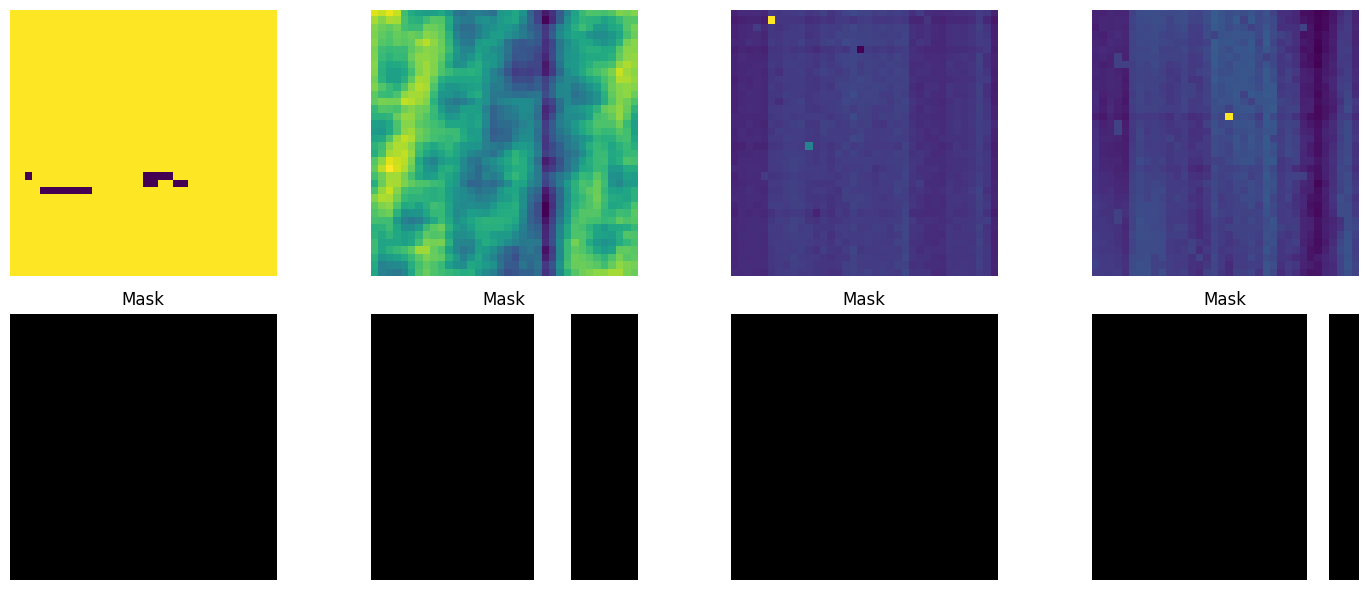

In [17]:
for images, masks,image_path,mask_path in train_loader:
    num_images_to_plot = min(4, len(images))

    fig, axes = plt.subplots(2, num_images_to_plot, figsize=(15, 6))

    for i in range(num_images_to_plot):
        axes[0, i].imshow(images[i])
        #axes[0, i].set_title(image_path[i])
        #print(image_path[i])
        #print(mask_path[i])
        axes[0, i].axis('off')

        axes[1, i].imshow(masks[i], cmap='gray')
        axes[1, i].set_title('Mask')
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()
    break

Трансформацию данных лучше делать отдельно от датасета и присоединять при его инициализации - вместо
```
transform = False
```
использовать, например, внешнюю функцию ```apply_numpy_transform```:
```
transform = apply_numpy_transform
```
Подходы к трансформации данных в обучающей и валидационной/ тестовой выборках отличаются:
* В валидационной/ тестовой выборке зачастую достаточно трансформировать данные в torch.Tensor

Идеи для аугментации данных можно почерпнуть в библитеке torchvision.transforms.v2

Например:
1. Вращение в диапазоне от -15° и +15° - v2.RandomRotation
2. Обрезка - v2.RandomResizedCrop
3. Размытие до 1,75 пикселей - v2.GaussianBlur
4. Добавление шума до 10% пикселей
5. Регулировка яркости между -50% и +50% - v2.functional.adjust_brightness
6. Данные у нас находятся в диапазоне -0.25 до 0.47 - можно подумать об их нормализации.

Важно проследить, чтобы маска обучающей выборки трансформировалась также как изображение.

Ниже - пример реализации SegmentationDataset:

In [18]:
def data_transform(sample: dict):
    """
    Apply horizontal and vertical flips with 50% probability
    """
    image = sample["image"]
    mask = sample["mask"]

    if np.random.random() > 0.5:
        image = np.fliplr(image)  # Horizontal flip
        mask = np.fliplr(mask)

    if np.random.random() > 0.5:
        image = np.flipud(image)  # Vertical flip
        mask = np.flipud(mask)

    sample = {"image": image, "mask": mask}

    return sample

In [19]:
class SegmentationDataset(Dataset):
    """Segmentation dataset."""

    def __init__(self, csv_file: str, root_dir: str, transform=None):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.mask_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.mask_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, f"{self.mask_frame.iloc[idx, 0]}.npy")
        image = np.nan_to_num(np.load(img_name))
        image = torch.from_numpy(image)
        mask = self.mask_frame.iloc[idx, 1:]
        mask = torch.from_numpy(np.array(mask, dtype=float).reshape(36, 36))

        # Label refinement
        mask = binary_fill_holes(mask)
        mask = self.apply_dilation(mask)

        sample = {"image": image, "mask": mask}

        if self.transform:
            sample = self.transform(sample)

        return sample

    def apply_dilation(self, mask):
        """
        Structuring Element & Morphological Operations
        """
        kernel_size = (2, 2)
        kernel_shape = cv2.MORPH_RECT
        # Create the adaptive structuring element
        adaptive_kernel = cv2.getStructuringElement(kernel_shape, kernel_size)
        # Apply morphological operations : dilation
        mask = cv2.dilate(np.ones((36, 36)) * mask, adaptive_kernel)

        return mask

In [20]:
stages = ["train", "val", "test"]
config = CONFIG

transform = {
    'train': data_transform,
    'val': None,
    'test': None
}
segmentation_datasets = {
    stage: SegmentationDataset(
        csv_file=os.path.join(config["save_dir"], f"y_{stage}.csv"),
        root_dir=config["root_dir"],
        transform=transform[stage]
    )
    for stage in stages
}
dataset_loader = {
    stage: torch.utils.data.DataLoader(
        segmentation_datasets[stage],
        batch_size=4,
        shuffle=np.where(stage == "train", True, False),
        num_workers=4,
    )
    for stage in stages
}
dataset_sizes = {stage: len(segmentation_datasets[stage]) for stage in stages}
dataset_sizes

{'train': 6439, 'val': 1985, 'test': 903}

* Таким образом, получаем data_preparation_pipeline:

In [21]:
def data_preparation_pipeline(
    config: Optional[dict] = None,
) -> Tuple[torch.utils.data.Dataset, torch.utils.data.DataLoader]:
    if config is None:
        config = CONFIG

    y_train, images_train = load_data(config)
    y_train, _ = clean_outliers(y_train, images_train)
    split_y_to_train_val_test(y_train)

    stages = ["train", "val", "test"]

    transform = {"train": data_transform, "val": None, "test": None}
    segmentation_datasets = {
        stage: SegmentationDataset(
            csv_file=os.path.join(config["save_dir"], f"y_{stage}.csv"),
            root_dir=config["root_dir"],
            transform=transform[stage],
        )
        for stage in stages
    }
    dataset_loader = {
        stage: torch.utils.data.DataLoader(
            segmentation_datasets[stage],
            batch_size=4,
            shuffle=np.where(stage == "train", True, False),
            num_workers=4,
        )
        for stage in stages
    }

    return segmentation_datasets, dataset_loader

100%|██████████| 9674/9674 [00:01<00:00, 9001.05it/s]


[1296, 2611, 812, 511]


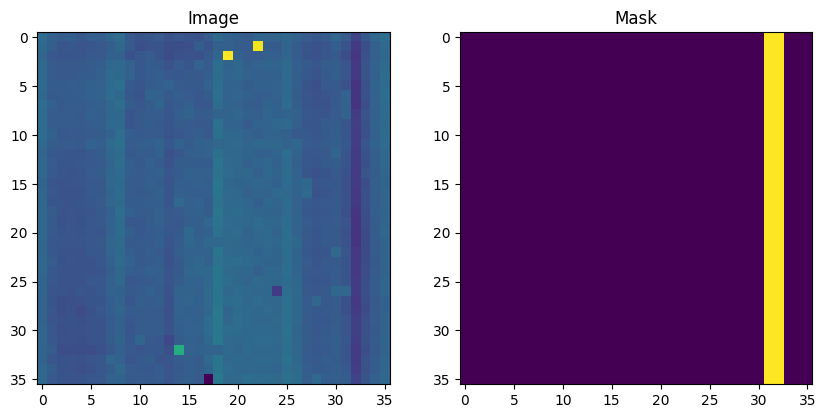

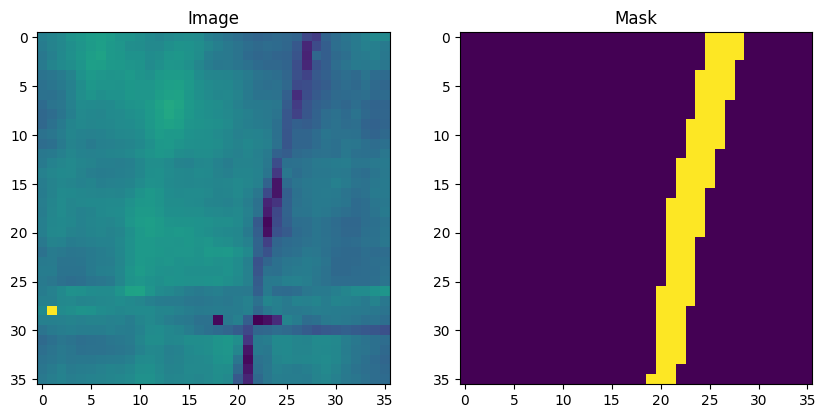

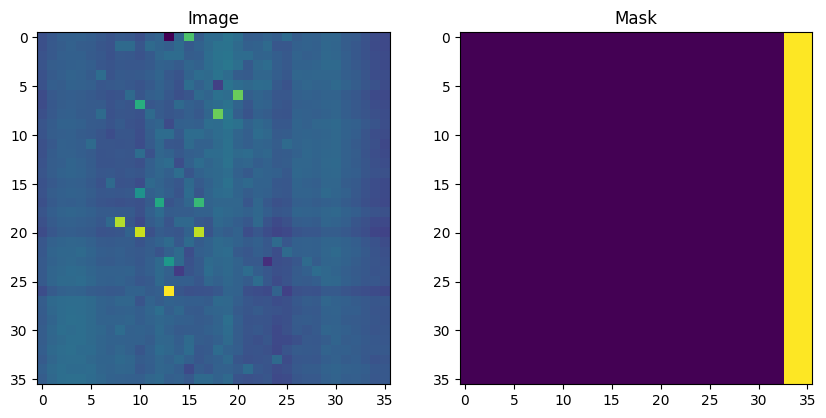

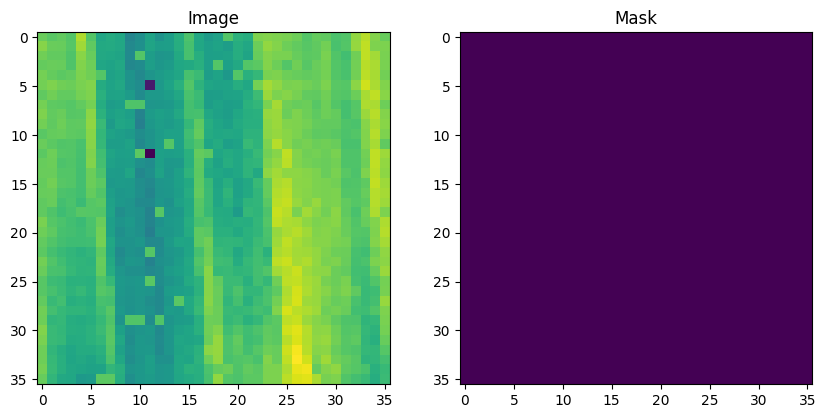

In [22]:
def show_image_and_mask(image, mask):
  """Show image and mask"""
  fig, axes = plt.subplots(1, 2, figsize=(10, 5))

  axes[0].imshow(image)
  axes[0].set_title('Image')
  axes[1].imshow(mask)
  axes[1].set_title('Mask')
  plt.show()

segmentation_datasets, dataset_loader = data_preparation_pipeline()

for i, batch in enumerate(dataset_loader["train"].batch_sampler):
  if i == 1:
    break

  print(batch)

  for idx in batch:
    selected_data = segmentation_datasets["train"][idx]
    show_image_and_mask(**selected_data)


## Рекомендации

1. До генерации датасета имеет смысл очистить данные от выбросов. Порог, после которого начиаются выбросы, определеяется на этапе EDA:
```
csv_file="../data/raw/y_train.csv"
root_dir="/content/cv-segmentation/data/raw/images/"
y_train, images_train = load_data(csv_file, root_dir)
y_train, _ = clean_outliers(y_train, images_train)
```
2. Лучше отказаться от дублирования данных обучающей выборки в папке ```data/interim/```. Достаточно разбить y_train на 3 файла: ```y_train.csv```, ```y_val.csv``` и ```y_test.csv```  и поместить их в папку ```data/interim/```.
Тестовая выборка, в дополнение к валидационной, потребуется для анализа ошибок моделей.

3. Чтобы избежать data leakage, данные на обучающую, валидационную и тестовую выборки разбиваем в разрезе скважин, чтобы снимки и разметка каждой скважины появлялись только в одном блоке. Отбор скважин для каждого блока делаем на этапе EDA.
```
split_y_to_train_val_test(y_train)
```
4. Трансформацию данных лучше делать отдельно от датасета и присоединять при его инициализации - вместо
```
transform = False
```
использовать, например, внешнюю функцию ```apply_numpy_transform```:
```
transform = apply_numpy_transform
```
Подходы к трансформации данных в обучающей и валидационной/ тестовой выборках отличаются:
  * В валидационной/ тестовой выборке зачастую достаточно трансформировать данные в torch.Tensor

5. Идеи для аугментации данных можно почерпнуть в библитеке torchvision.transforms.v2

  Например:
  - Вращение в диапазоне от -15° и +15° - v2.RandomRotation
  - Обрезка - v2.RandomResizedCrop
  - Размытие до 1,75 пикселей - v2.GaussianBlur
  - Добавление шума до 10% пикселей
  - Регулировка яркости между -50% и +50% - v2.functional.adjust_brightness
  - Данные у нас находятся в диапазоне -0.25 до 0.47 - можно подумать об их нормализации.

  Важно проследить, чтобы маска обучающей выборки трансформировалась также как изображение.

Пример реализации SegmentationDataset и иллюстрация работы DataLoader в рамках data_preparation_pipeline - выше в коде этого ноутбука.